# Spotify Wrapped Plus
By Carson Duffy
- Linkedin: Click [here](https://www.linkedin.com/in/carson-duffy-19940a18a/)
- GitHub: Click [here](https://github.com/cwduffy01)

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# color scheme (from Spotify's app)
green = "1db954"
dark_grey = "212121"
grey = "535353"
light_grey = "b3b3b3"

# default matplotlib settings
mpl.rcParams["figure.figsize"] = (9.0, 6.0)

# default seaborn settings
sns.set_style(
    rc = {
        "axes.facecolor": dark_grey,
        "axes.edgecolor": light_grey,
        "figure.facecolor": dark_grey,
        "axes.grid": True,
        "grid.color": grey,
        "xtick.color": light_grey,
        "ytick.color": light_grey,
        "text.color": light_grey,
        "axes.labelcolor": light_grey
    }
)

sns.set_context(
    rc={
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "legend.title_fontsize": 14
    }
)

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify app for gathering information
cid = '8e1c7b5c9c8d45c1a4d531c85edd4c51'
secret = '6f43fe6e7dce4e6e96046764f9e4f440'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Data Acquisition and Preprocessing

In [4]:
year = 2020     # CHANGE THIS VARIABLE TO CHANGE THE YEAR
df = pd.read_csv(f"StreamingHistory/{year}.csv")

In [5]:
# rename columns for easier access
df = df.rename(columns={
    "master_metadata_track_name": "track_name",
    "master_metadata_album_artist_name": "artist_name",
    "master_metadata_album_album_name": "album_name"
})

In [6]:
# filter columns for track-specific information
track_hist = df[["ts", "ms_played", "track_name", "artist_name", "album_name"]]
track_hist = track_hist[track_hist.ms_played >= 10000]  # drop data if track was skipped early
track_hist.dropna(inplace=True)     # drop podcast rows

In [7]:
# filter columns for podcast-specific information
epi_hist = df[["ts", "ms_played", "episode_name", "episode_show_name"]]
epi_hist = epi_hist[epi_hist.ms_played >= 10000]    # drop data if podcast was skipped early
epi_hist.dropna(inplace=True)   # drop track rows

In [8]:
# parse timestamp column into individual values
track_hist["year"] = track_hist.ts.str[:4]
track_hist["month"] = track_hist.ts.str[5:7]
track_hist["day"] = track_hist.ts.str[8:10]
track_hist["hour"] = track_hist.ts.str[11:13]

In [9]:
try:
    track_info = pd.read_csv(f"TrackInfo/{year}.csv")
except FileNotFoundError:
    # gather track, artist, and album information of each unique track in streaming history
    # if the information csv file doesn't exist, this will take a while to execute
    group = track_hist.groupby(["artist_name", "album_name", "track_name"]).sum()
    track_info = pd.DataFrame(index=group.index, columns=['duration_ms', 'explicit', 'track_popularity', 'danceability', 
                                                          'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                                          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 
                                                          'artist_genres', 'artist_popularity', 'album_genres', 'album_type', 
                                                          'album_popularity', 'release_date', 'release_date_precision'])

    percents = []   # list to keep track of progress

    for key, value in track_info.iterrows():
        try:
            query = f"artist:{key[0]} album:{key[1]} track:{key[2]}"    # try query with tags
            track = sp.search(q=query, limit=1, type='track')["tracks"]["items"][0]
        except:
            try:
                query = f"artist:{key[0]} track:{key[2]}"    # try query with tags
                track = sp.search(q=query, limit=1, type='track')["tracks"]["items"][0]
            except:
                try:
                    query = f"{key[0]} {key[2]}"    # try query with tags
                    track = sp.search(q=query, limit=1, type='track')["tracks"]["items"][0]
                except:
                    track = None
        
        # add track, artist, and album features to DataFrame
        try:
            features = sp.audio_features(track["uri"])[0]
            artist = sp.artist(track["artists"][0]["uri"]) 
            album = sp.album(track["album"]["uri"])

            track["track_popularity"] = track["popularity"]
            artist["artist_popularity"] = artist["popularity"]
            artist["artist_genres"] = '; '.join(artist["genres"])
            album["album_popularity"] = album["popularity"]
            album["album_genres"] = '; '.join(album["genres"])


            t_keys = ['duration_ms', 'explicit', 'track_popularity']
            f_keys = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
            ar_keys = ['artist_genres', 'artist_popularity']
            al_keys = ['album_genres', 'album_type', 'album_genres', 'album_popularity', 
                       'release_date', 'release_date_precision']

            ddict = {key: track[key] for key in t_keys}
            ddict.update({key: features[key] for key in f_keys})
            ddict.update({key: artist[key] for key in ar_keys})
            ddict.update({key: album[key] for key in al_keys})
            
            track_info.loc[key] = ddict
        except:     # if information isn't present for some reason
            pass

        # update and print progress
        p = track_info.index.get_loc(key) / track_info.shape[0] * 100
        if int(p) not in percents and int(p) % 5 == 0:
            percents.append(int(p))
            print('|' + ('#' * int(p/5)).ljust(20) + '|' + f" {int(p)}%")
    
    # save as csv
    try:
        track_info.to_csv(f"TrackInfo/{year}.csv", index=False)
    except:
        os.mkdir("TrackInfo")
        track_info.to_csv(f"TrackInfo/{year}.csv", index=False)

In [10]:
# merge track_hist with track_info
track_hist = track_hist.set_index(["artist_name", "album_name", "track_name"])
track_hist = pd.merge(track_hist, track_info, on=["artist_name", "album_name", "track_name"])

In [11]:
# add column for track plays
track_hist["plays"] = track_hist.ms_played / track_hist.duration_ms

## Listening Statistics

In [12]:
tot_time = int(track_hist.ms_played.sum() / (1000 * 60 * 60))   # convert milliseconds to hours
print(f"You listened to {tot_time:,} hours of music this year!")

You listened to 796 hours of music this year!


In [13]:
num_tracks = len(track_hist.track_name.unique())
num_albums = len(track_hist.album_name.unique())
num_artists = len(track_hist.artist_name.unique())

print(f"You listened to {num_tracks:,} tracks from {num_albums:,} albums by {num_artists:,} artists this year!")

You listened to 3,783 tracks from 2,314 albums by 1,680 artists this year!


In [14]:
num_epis = len(epi_hist.episode_name.unique())
num_shows = len(epi_hist.episode_show_name.unique())

print(f"You listened to {num_epis:,} podcast episodes from {num_shows:,} shows this year!")

You listened to 3 podcast episodes from 3 shows this year!


## Music vs. Podcasts 

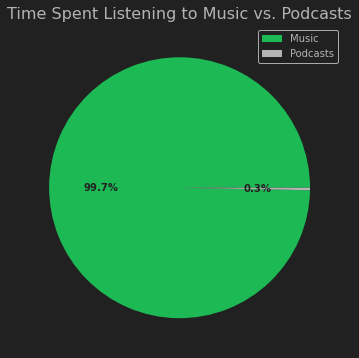

In [15]:
track_time = track_hist.ms_played.sum()
pod_time = epi_hist.ms_played.sum()

# create plot
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie([track_time, pod_time], colors=[f"#{green}", f"#{light_grey}"], 
                                  autopct='%1.1f%%', textprops=dict(color=f"#{dark_grey}", weight="bold"));

# format plot
ax.set_title("Time Spent Listening to Music vs. Podcasts")
types = ["Music", "Podcasts"]
ax.legend(wedges, types);   # create legend

## Top Genres

In [16]:
mp = track_hist.groupby("artist_name").sum()[["ms_played"]]     # total listening time per artist
gn = track_hist[["artist_name", "artist_genres"]].drop_duplicates().dropna().set_index("artist_name")   # genres per artist

In [17]:
genre_df = pd.DataFrame(columns=["genre", "ms_played"])     # total listening time per genre

for key, value in pd.merge(mp, gn, on="artist_name").iterrows():    # iterate through merged mp and gn
    for genre in value.artist_genres.split("; "):   # add row in DataFrame for each genre
        genre_df = genre_df.append({
            "genre": genre,
            "ms_played": value.ms_played
        }, ignore_index=True)

genre_df = genre_df.groupby("genre").sum()  # sum ms_played values for each genre

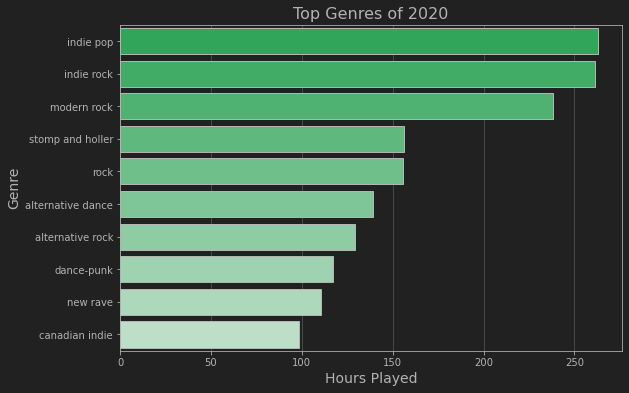

In [18]:
top10_genres = genre_df.sort_values("ms_played", ascending=False).head(10)

# create plot
fig, ax = plt.subplots()
plot = sns.barplot(y=top10_genres.index, x=top10_genres.ms_played / (1000 * 60 * 60), edgecolor=f"#{light_grey}",
                   palette=sns.light_palette(color=f"#{green}", n_colors=13, reverse=True)[:10])

# format plot
ax.set_axisbelow(True)
ax.set_title(f"Top Genres of {year}")
ax.set_xlabel("Hours Played")
ax.set_ylabel("Genre");

## Top Tracks for Each Month

In [19]:
by_month = track_hist.groupby(["year", "month", "artist_name", "track_name"]).sum()[["plays"]]
by_month = by_month[by_month.plays.isin(by_month.groupby("month").max().plays)]     # gets max plays for each month

by_month = by_month.reset_index(level=(2, 3))   # artist_name and track_name added to columns
by_month = by_month.reset_index(level=0, drop=True)     # drop year
by_month["title"] = by_month.artist_name + " - " + by_month.track_name  # create title column
by_month = by_month.drop(["artist_name", "track_name"], axis=1)     # drop artist_name and track_name columns

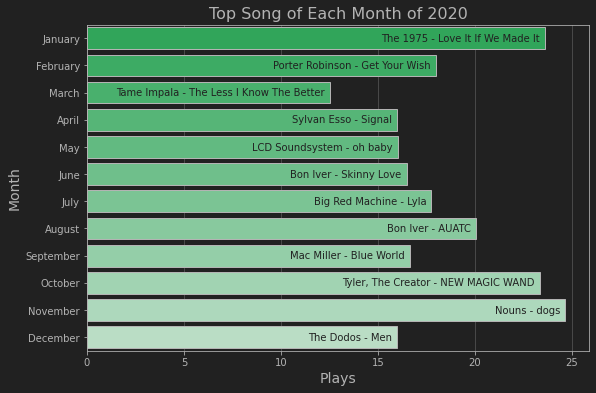

In [20]:
# create plot
fig, ax = plt.subplots()
fig.canvas.draw()   # necessary to get annotation bounding boxes 
plot = sns.barplot(y=by_month.index, x=by_month.plays, edgecolor=f"#{light_grey}",
                   palette=sns.light_palette(color=f"#{green}", n_colors=16, reverse=True)[:12])

# add track names to bars
for i in range(len(plot.patches)):
    # add initial annotation inside of bar
    p = plot.patches[i]
    ann = plot.annotate(by_month.iloc[i].title,
                        (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha="right", va="center",
                        xytext=(-5, 0),
                        textcoords="offset points",
                        color=f"#{dark_grey}")
    text_bbox = ann.get_window_extent()
    if text_bbox.get_points()[0][0] < ax.bbox.get_points()[0][0]:   # if text goes behind y-axis (too long)
        ann.remove()
        # add annotation outside of bar instead
        ann = plot.annotate(by_month.iloc[i].title,
                            (p.get_width(), p.get_y() + p.get_height() / 2),
                            ha="left", va="center",
                            xytext=(5, 0),
                            textcoords="offset points",
                            color=f"#{light_grey}")

# format plot       
ax.set_axisbelow(True)
ax.set_title(f"Top Song of Each Month of {year}")
ax.set_xlabel("Plays")
ax.set_ylabel("Month")
ax.set_yticklabels(["January", "February", "March", "April", "May", "June", "July", 
                    "August", "September", "October", "November", "December"]);

## Daily Listening Statistics for Each Month

In [21]:
month_values = track_hist.groupby(["month", "day"]).sum()[["ms_played"]]    # daily ms_played sums for each month
month_values = month_values.reset_index(level=1, drop=True)     # drop day index

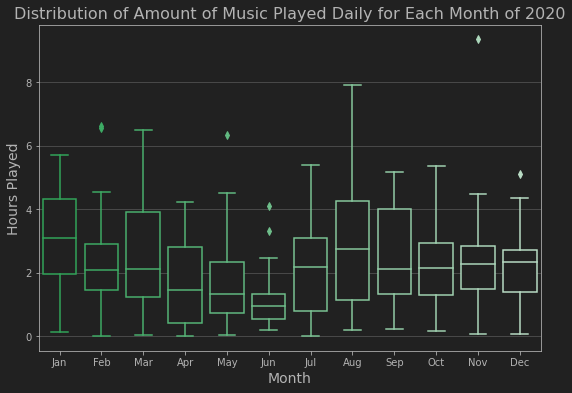

In [22]:
# create plot
fig, ax = plt.subplots()
sns.boxplot(x=month_values.index, y=month_values.ms_played / (1000 * 60 * 60),
            palette=sns.light_palette(color=f"#{green}", n_colors=16, reverse=True)[:12])

for i,artist in enumerate(ax.artists):
    # set line color of box to face color, set face color to background color of plot
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor(f"#{dark_grey}")

    # iterate through line colors and use the same color as above
    for j in range(i * 6, i * 6 + 6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# format plot
ax.set_axisbelow(True)
ax.set_title(f"Distribution of Amount of Music Played Daily for Each Month of {year}")
ax.set_ylabel("Hours Played")
ax.set_xlabel("Month")
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]);

## Audio Feature Statistics 

In [23]:
top_global_tracks_info = pd.DataFrame()     # track features of top 50 tracks of the year

query = f"Top+Tracks+of+{year}"     # top 50 tracks are found in Spotify's playlist
pl = sp.search(q=query, limit=1, type="playlist")
uri = pl["playlists"]["items"][0]["uri"]
playlist = sp.playlist(uri)
track_uris = [track["track"]["uri"] for track in playlist["tracks"]["items"]]   # uris of each track inthe playlist

f_keys = ["acousticness", "danceability", "energy", "instrumentalness", 
          "liveness", "loudness", "speechiness", "valence", "tempo"]
for uri in track_uris:  # track features for each track
    features = sp.audio_features(uri)[0]
    ddict = {key: features[key] for key in f_keys}
    top_global_tracks_info = top_global_tracks_info.append(ddict, ignore_index=True)    # add to DataFrame

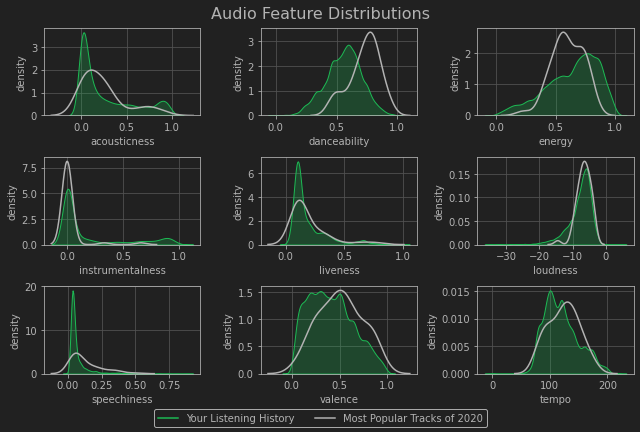

In [24]:
# create kdeplot for each feature
fig, ax = plt.subplots(nrows=3, ncols=3)
values = [["acousticness", "danceability", "energy"], 
          ["instrumentalness", "liveness", "loudness"], 
          ["speechiness", "valence", "tempo"]]
for i in range(len(values)):
    for j in range(len(values[i])):
        sns.kdeplot(track_hist[values[i][j]].values, color=f"#{green}", 
                    shade=True, ax=ax[i][j])    # graph listening history distribution
        sns.kdeplot(top_global_tracks_info[values[i][j]].values, color=f"#{light_grey}", 
                    shade=False, ax=ax[i][j])  # graph top tracks distribution
        ax[i][j].set_xlabel(values[i][j], size=10.0)
        ax[i][j].set_ylabel("density", size=10.0)
        ax[i][j].tick_params(axis="both", labelsize=10.0)
        ax[i][j].set_axisbelow(True)

# format plot
fig.tight_layout()
# create legend
lh = mpl.lines.Line2D([], [], color=f"#{green}", label="Your Listening History")
mp = mpl.lines.Line2D([], [], color=f"#{light_grey}", label=f"Most Popular Tracks of {year}")
fig.legend(handles=[lh, mp], loc='lower center', ncol=2)
fig.suptitle("Audio Feature Distributions", fontsize=16)
fig.subplots_adjust(top=0.93, bottom=0.13)

Spotify defines the above terms as such:
- **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **Danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- **Speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- **Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.


## Top 10 Tracks over Time

In [25]:
# get top 10 tracks over the year
top_tr = track_hist.groupby(["artist_name", "track_name"]).sum()[["plays"]]
top10_tr = top_tr.sort_values("plays", ascending=False).head(10)

In [26]:
# filter history to include only entries that have one of the top 10 tracks
top10_tr_hist = track_hist[track_hist.artist_name.isin(top10_tr.index.get_level_values(level="artist_name")) &
                           track_hist.track_name.isin(top10_tr.index.get_level_values(level="track_name"))]

In [27]:
# DataFrame reformatting
top10_tr_hist.insert(0, "date", top10_tr_hist.ts.str[:10])  # parse date from timestamp
top10_tr_hist.insert(0, "title", top10_tr_hist.artist_name + " - " + top10_tr_hist.track_name)  # add title column
by_date_tr = top10_tr_hist.groupby(["date", "title"]).sum()[["plays"]].unstack("title")     # move title to columns

In [28]:
# add blank entries for missing dates
d = datetime(year=year, day=1, month=1)
while d < datetime(year=year+1, day=1, month=1):
    if d.strftime("%Y-%m-%d") not in by_date_tr.index:
        row = pd.DataFrame(index=[d.strftime("%Y-%m-%d")], columns=by_date_tr.columns)   # create empty row
        by_date_tr = by_date_tr.append(row)   # add row to DataFrame
    d += timedelta(days=1)
by_date_tr = by_date_tr.sort_index().fillna(0.)     # sort by date and replace nan with 0.0

In [29]:
by_date_tr_c = by_date_tr.plays.cumsum()    # create cumulative sum dataframe
# sort columns by total listens so they are ranked in the plot legend
by_date_tr_c = by_date_tr_c.sort_values(by_date_tr_c.iloc[-1].name, ascending=False, axis=1)

In [30]:
# move title from column to rows for seaborn plotting
by_date_tr_c = by_date_tr_c.stack("title").reset_index(level=1)
by_date_tr_c = by_date_tr_c.rename({0:"plays"}, axis=1)     # rename column

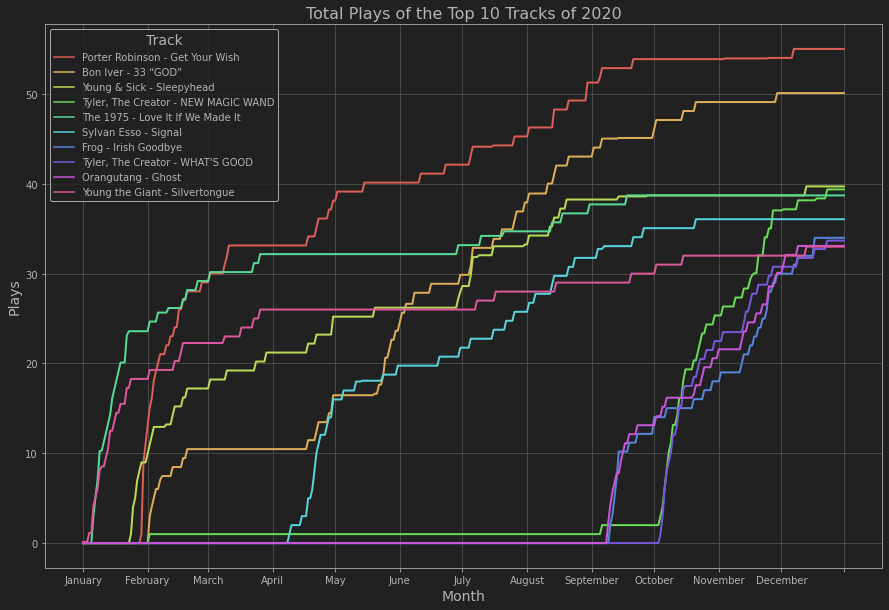

In [31]:
# create plot
fig, ax = plt.subplots(figsize=(15.0, 10.0))
sns.lineplot(x=by_date_tr_c.index, y=by_date_tr_c.plays, data=by_date_tr_c, 
             hue=by_date_tr_c.title, ax=ax, linewidth=2, palette="hls")

# format plot
ax.set_title(f"Total Plays of the Top 10 Tracks of {year}")
ax.set_xlabel("Month")
ax.set_ylabel("Plays")
ax.legend(title="Track")
# replace xticks with month names instead of dates
xticks = [f"{year}-{str(i).zfill(2)}-01" for i in range(1, 13)]
xticks.append(f"{year}-12-31")
ax.set_xticks(xticks)
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July", 
                    "August", "September", "October", "November", "December", ""]);

## Top 5 Albums over Time

In [32]:
# get top 5 albums over the year
top_albums = track_hist.groupby(["artist_name", "album_name"]).sum()[["plays"]]
top5_al = top_albums.sort_values("plays", ascending=False).head()

In [33]:
# filter history to include only entries that have one of the top 5 albums
top5_al_hist = track_hist[track_hist.artist_name.isin(top5_al.index.get_level_values(level="artist_name")) &
                          track_hist.album_name.isin(top5_al.index.get_level_values(level="album_name"))]

In [34]:
# DataFrame reformatting
top5_al_hist.insert(0, "date", top5_al_hist.ts.str[:10])  # parse date from timestamp
top5_al_hist.insert(0, "title", top5_al_hist.artist_name + " - " + top5_al_hist.album_name)  # add title column
by_date_al = top5_al_hist.groupby(["date", "title"]).sum()[["plays"]].unstack("title")  # move title to columns

In [35]:
# add blank entries for missing dates
d = datetime(year=year, day=1, month=1)
while d < datetime(year=year+1, day=1, month=1):
    if d.strftime("%Y-%m-%d") not in by_date_al.index:
        row = pd.DataFrame(index=[d.strftime("%Y-%m-%d")], columns=by_date_al.columns)   # create empty row
        by_date_al = by_date_al.append(row)   # add row to DataFrame
    d += timedelta(days=1)
by_date_al = by_date_al.sort_index().fillna(0.)     # sort by date and replace nan with 0.0

In [36]:
by_date_al_c = by_date_al.plays.cumsum()    # create cumulative sum dataframe
# sort columns by total listens so they are ranked in the plot legend
by_date_al_c = by_date_al_c.sort_values(by_date_al_c.iloc[-1].name, ascending=False, axis=1)

In [37]:
# move title from column to rows for seaborn plotting
by_date_al_c = by_date_al_c.stack("title").reset_index(level=1)
by_date_al_c = by_date_al_c.rename({0:"plays"}, axis=1)

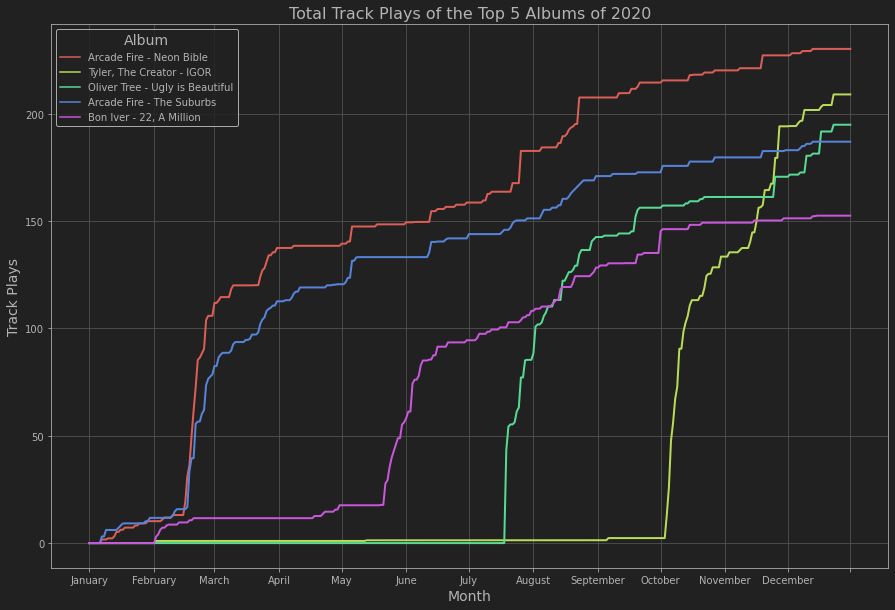

In [38]:
# create plot
fig, ax = plt.subplots(figsize=(15.0, 10.0))
sns.lineplot(x=by_date_al_c.index, y=by_date_al_c.plays, data=by_date_al_c, 
             hue=by_date_al_c.title, ax=ax, linewidth=2, palette="hls")

# format plot
ax.set_title(f"Total Track Plays of the Top 5 Albums of {year}")
ax.set_xlabel("Month")
ax.set_ylabel("Track Plays")
ax.legend(title="Album")
# replace xticks with month names instead of dates
xticks = [f"{year}-{str(i).zfill(2)}-01" for i in range(1, 13)]
xticks.append(f"{year}-12-31")
ax.set_xticks(xticks)
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July", 
                    "August", "September", "October", "November", "December", ""]);

## Top 5 Artists over Time

In [39]:
# get top 5 artists over the year
top_artists = track_hist.groupby("artist_name").sum()[["plays"]]
top5_ar = top_artists.sort_values("plays", ascending=False).head(5)

In [40]:
# filter history to include only entries that have one of the top 5 artists
top5_ar_hist = track_hist[(track_hist.artist_name.isin(top5_ar.index.get_level_values(level="artist_name")))]

In [41]:
# DataFrame reformatting
top5_ar_hist.insert(0, "date", top5_ar_hist.ts.str[:10])     # parse date from timestamp
by_date_ar = top5_ar_hist.groupby(["date", "artist_name"]).sum()[["plays"]].unstack("artist_name")  # move artist to columns

In [42]:
# add blank entries for missing dates
d = datetime(year=year, day=1, month=1)
while d < datetime(year=year+1, day=1, month=1):
    if d.strftime("%Y-%m-%d") not in by_date_ar.index:
        row = pd.DataFrame(index=[d.strftime("%Y-%m-%d")], columns=by_date_ar.columns)   # create empty row
        by_date_ar = by_date_ar.append(row)   # add row to DataFrame
    d += timedelta(days=1)
by_date_ar = by_date_ar.sort_index().fillna(0.)     # sort by date and replace nan with 0.0

In [43]:
by_date_ar_c = by_date_ar.plays.cumsum()    # create cumulative sum dataframe
# sort columns by total listens so they are ranked in the plot legend
by_date_ar_c = by_date_ar_c.sort_values(by_date_ar_c.iloc[-1].name, ascending=False, axis=1)

In [44]:
# move title from column to rows for seaborn plotting
by_date_ar_c = by_date_ar_c.stack("artist_name").reset_index(level=1)
by_date_ar_c = by_date_ar_c.rename({0:"plays"}, axis=1)

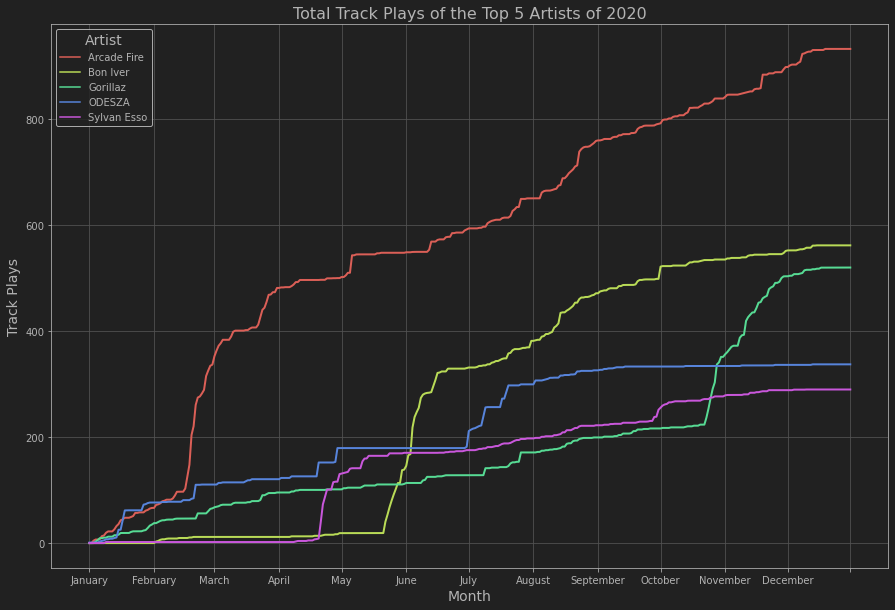

In [45]:
# create plot
fig, ax = plt.subplots(figsize=(15.0, 10.0))
sns.lineplot(x=by_date_ar_c.index, y=by_date_ar_c.plays, data=by_date_ar_c, 
             hue=by_date_ar_c.artist_name, ax=ax, linewidth=2, palette="hls")

# format plot
ax.set_title(f"Total Track Plays of the Top 5 Artists of {year}")
ax.set_xlabel("Month")
ax.set_ylabel("Track Plays")
ax.legend(title="Artist")
# replace xticks with month names instead of dates
xticks = [f"{year}-{str(i).zfill(2)}-01" for i in range(1, 13)]
xticks.append(f"{year}-12-31")
ax.set_xticks(xticks)
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July", 
                    "August", "September", "October", "November", "December", ""]);